# Procesamiento de Lenguaje Natural

Disponibilizo a continuación el link al repositorio de [Github](https://github.com/JuanOrtolani/NLP-Sentiment-Analysis-of-Amazon-Reviews-Part-II-)

El objetivo de este proyecto será profundizar y mejorar la resolución de la anterior entrega N°3.   
A partir del desarrollo presentado por mis compañeros en las demos, el material disponibilizado por Acámica y profundizando con bibliografía extra identifiqué algunos ajustes que podía añadir a mi proyecto.

El proyecto anterior se organizaba en tres partes:

   * PARTE A: Exploración y Transformación de datos
   * PARTE B: Modelos de Machine Learning 
   * PARTE C: Investigación/Interpretación de los datos
   
Para cada una de ellas encontré nuevas ideas/hipótesis que podrían traer mejoras:
   * PARTE A: Análisis de bigramas y trigramas para verificar consistencia en el preprocesamiento.
   * PARTE B: Como pudimos comprobar, el tiempo de ejecución de la técnica de hiperoptimización seleccionada anteriormente es excesivamente elevado. Investigando en la web encontré la librería [skopt](http://scikit-optimize.github.io/stable/) que permite trabajar con optimización bayesiana la cuál reduce considerablemente los tiempos de ejecución con resultados iguales o mejores a la técnica utilizada anteriormente.
   * PARTE C: Partiendo de las conclusiones obtenidas en el proyecto 3 defino dos puntos de partida para el proyecto 4:  
       - Conclusión 1: Los modelos presentan dificultad al distingir los valores medios del rango de calificación (1 a 5) --> Para contrarestar esta complicación agruparé las calificaciones de la siguiente manera
       
   
   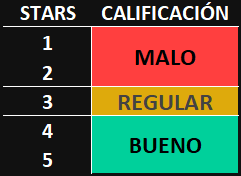
   
       - La combinación entre técnicas de vectorización y tokenización de mejor performance es Stemmización + TF-IDF


Comenzaremos con una breve exploración del dataset para conocer un poco acerca del conjunto de datos con el se trabajará. 

### Exploración
A) Carga de datos y librerías

Comenzamos cargando las librerías y dataset a utilizar. Es imporarte tener en cuenta que la librería NLTK debe configurarse.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
import nltk
import re

# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
amazon_dataset = pd.read_json('dataset_es_dev.json', lines= True)
amazon_dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


Creamos una lista de condiciones para crear las nuevas calificaciones propuestas anteriormente

In [3]:
conditionlist = [
    (amazon_dataset['stars'] == 1),
    (amazon_dataset['stars'] == 2),
    (amazon_dataset['stars'] == 3),
    (amazon_dataset['stars'] == 4),
    (amazon_dataset['stars'] == 5)]
choicelist = ['Malo', 'Malo', 'Regular', 'Bueno', 'Bueno']
amazon_dataset['calificacion'] = np.select(conditionlist, choicelist, default='Not Specified')
amazon_dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,calificacion
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,Malo
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,Malo
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,Malo
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,Malo
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,Malo


B) Datatypes check para verificar si es necesario realizar conversiones o no

In [4]:
amazon_dataset.dtypes

review_id           object
product_id          object
reviewer_id         object
stars                int64
review_body         object
review_title        object
language            object
product_category    object
calificacion        object
dtype: object

Es importante también analizar si el dataset contiene más de un idioma o no para determinar la manera de trabajarlo

In [5]:
amazon_dataset['language'].value_counts()

es    5000
Name: language, dtype: int64

A simple vista, no pareciera necesário hacer conversiones. El dataset sólo contiene datos en español y los tipos de datos de todas las columnas están OK

C) Check filas duplicadas

In [6]:
filas_duplicadas = amazon_dataset[amazon_dataset.duplicated()]
print('Cantidad de filas duplicadas:', filas_duplicadas.shape[0])

Cantidad de filas duplicadas: 0


No hay filas duplicadas que eliminar

D) Tamaño del dataset, rango de calificación, cantidad de instancias por rango y categoría.

In [7]:
print('Filas -->', amazon_dataset.shape[0],'\nColumnas -->', amazon_dataset.shape[1])

Filas --> 5000 
Columnas --> 9


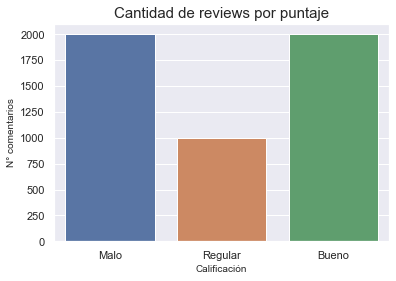

Malo       2000
Bueno      2000
Regular    1000
Name: calificacion, dtype: int64

In [8]:
sns.countplot(amazon_dataset.calificacion)
plt.title('Cantidad de reviews por puntaje', fontsize=15)
plt.ylabel('N° comentarios', fontsize=10)
plt.xlabel('Calificación', fontsize=10)
plt.show()
amazon_dataset['calificacion'].value_counts()

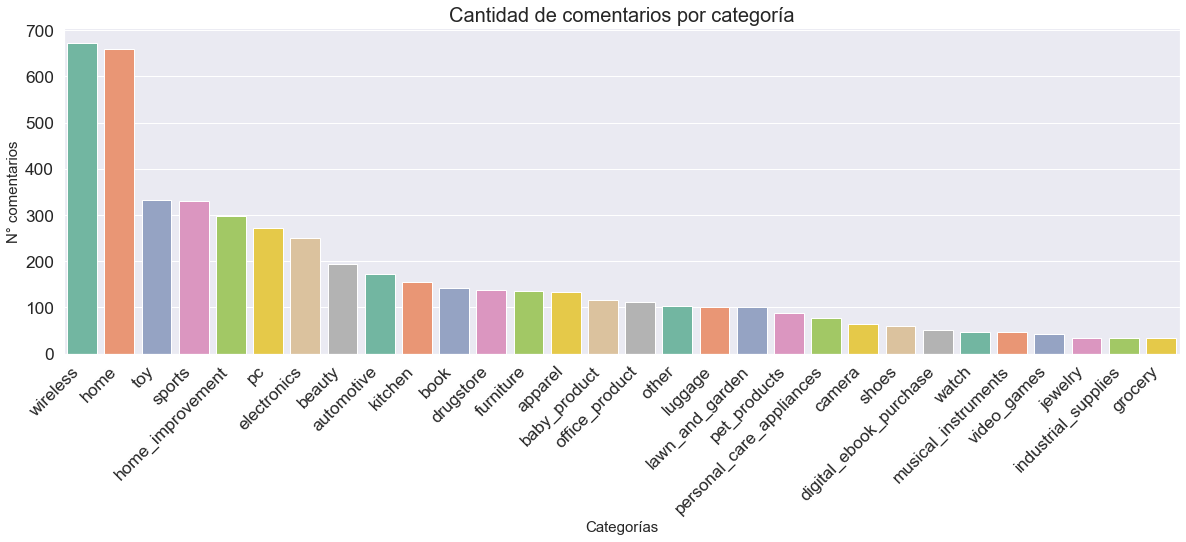

wireless                    672
home                        659
toy                         332
sports                      331
home_improvement            299
pc                          273
electronics                 251
beauty                      195
automotive                  173
kitchen                     156
book                        142
drugstore                   137
furniture                   135
apparel                     133
baby_product                117
office_product              112
other                       103
luggage                     101
lawn_and_garden             101
pet_products                 89
personal_care_appliances     77
camera                       64
shoes                        60
digital_ebook_purchase       51
watch                        47
musical_instruments          46
video_games                  43
jewelry                      34
industrial_supplies          34
grocery                      33
Name: product_category, dtype: int64

In [9]:
plt.figure(figsize = (20,6))
sns.countplot(data = amazon_dataset, x = 'product_category', order = amazon_dataset['product_category'].value_counts().index,palette='Set2')
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light', fontsize='x-large')
plt.yticks(rotation=0, horizontalalignment='right',fontweight='light', fontsize='x-large')
plt.title('Cantidad de comentarios por categoría', fontsize=20)
plt.ylabel('N° comentarios', fontsize=15)
plt.xlabel('Categorías', fontsize=15)
plt.show()
amazon_dataset['product_category'].value_counts()

Por último, veamos un análisis descriptivo para cada categoría según stars asignadas

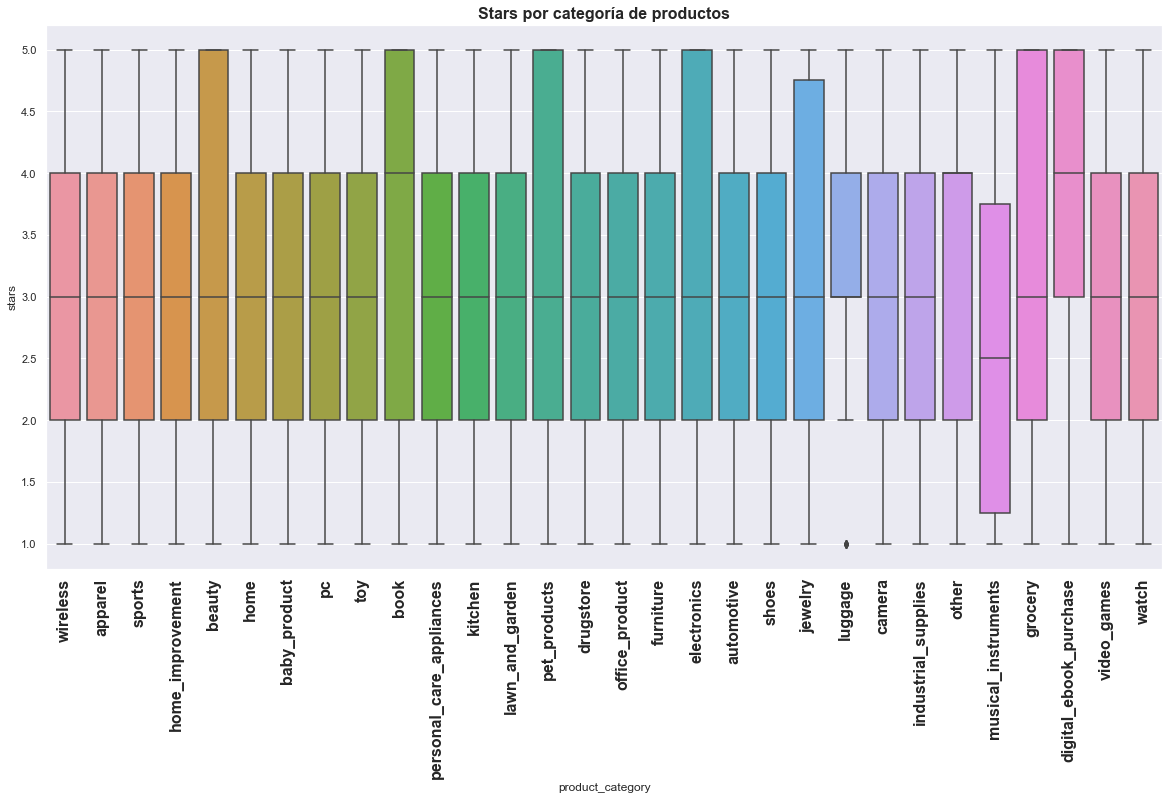

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.boxplot(x='product_category', y='stars', data=amazon_dataset)
ax.set_title('Stars por categoría de productos',
             fontsize=16, weight="bold")
plt.xticks(rotation = 90, fontsize=16, weight="bold")
plt.show()

### Preprocesamiento

Para continuar con el proyecto será necesario realizar un Preprocesamiento a los datos.  
Desarrollaremos en las siguientes celdas una serie de pasos a través de los cuales iremos preparando los mismos para poder volcarlos a modelos de ML que nos ayuden con nuestro objetivo.

#### Normalización

##### 1. Regex

Las expresiones regulares (regular expressions) o regex son una herramienta incluida en muchos lenguajes de programación que nos permite buscar texto a través de ciertas reglas definidas.
En Python, la librería para hacer esto se llama `re`.

En este caso, vamos a utilizar dicha librería para reemplazar los caracteres que no sean letras por espacios.

Al principio, aplicaremos estos pasos solamente a una review al azar para entender como funcionan y luego lo aplicaremos sobre todo el dataset.

--> Random Review

In [11]:
random_review = amazon_dataset.iloc[4292,:].review_body
print(random_review)

Esta muy bien acabado, muy prácticos los bolsillos y con la cremallera se ajusta muy bien. Da muy buena presencia, no es el típico descartable.


In [12]:
regex_review=re.sub("[^a-zA-Z]"," ",str(random_review))
regex_review

'Esta muy bien acabado  muy pr cticos los bolsillos y con la cremallera se ajusta muy bien  Da muy buena presencia  no es el t pico descartable '

Como podemos observar, la función que acabamos de aplicar no considera letras como tal a aquellos caracteres que incluyan tildes, diéresis o virgulillas. Todos ellos son frecuentemente utilizados en el idioma español asi que deberemos ajustar la técnica.

Para ello, trabajaremos en `unicode`. Aquí, cada grafema (caracter) se descompone en su equivalencia de caracter base seguido de sus marcas como podemos ver en la imágen.

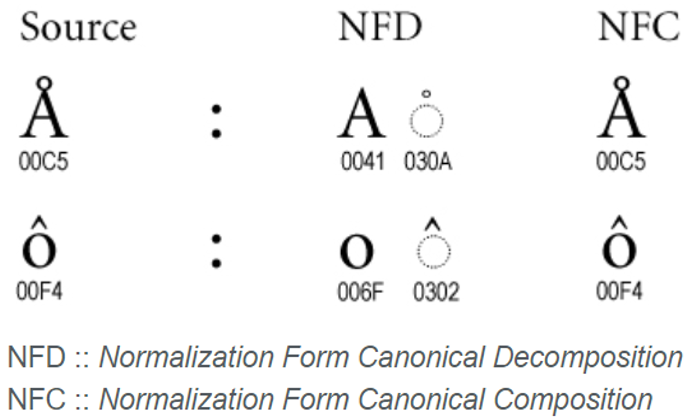

 
En la forma NFD, los diacríticos son puntos de código separados de su caracter base. Esto nos permite separar y eliminar lo que no queremos.

En este caso eliminaremos todas las marcas diacríticas excepto la `ñ`. Para ello, definiremos un regex donde el primer grupo es el caracter base y los diacríticos están fuera del grupo.  
Todas las marcas diacríticas están en un bloque en el rango `U+0300` - `U+036F` (Combining Diacritical Marks). Y vamos a hacer la excepción para `U+0303`, la virgulilla (~), pero sólo si está después de una n (reemplazando otras como una ã)
y sólo si no tiene otros diacríticos (reemplazando cosas raras como ñ͚͡). Con esto llegamos a la expresión:

   `([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+` donde:
    
* `([^n\u0300-\u036f])[\u0300-\u036f]+` -- > un caracter que no es una n ni un diacrítico, seguido de diacríticos.

* `(n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+` -- > una n que no está seguida por ~ (a menos que esta última esté seguida por otro diacrítico), entonces sí que coincida con todos los diacríticos que le siguen.

Luego, reemplazando por `\1` nos quedamos con la letra sin el diacrítico.  
Finalmente, una vez realizado la sustitución volveremos a la forma compuesta y convertiremos todo el texto a minúscula.

In [13]:
import re
import unicodedata
from unicodedata import normalize

regex_review = random_review


# -> NFD y eliminar diacríticos
regex_review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", regex_review), 0, re.I)
regex_review = re.sub("[^a-zA-Z]"," ",str(regex_review))


# -> NFC
regex_review = normalize( 'NFC', regex_review)

# -> Minúscula
regex_review = regex_review.lower()

print( regex_review )

esta muy bien acabado  muy practicos los bolsillos y con la cremallera se ajusta muy bien  da muy buena presencia  no es el tipico descartable 


#### Tokenización

Tokenizar hace referencia a separar textos por unidad semántica, ésto nos permite analizar cada unidad por separado.

Para ello utilizaremos la librería NLTK (Natural Language Tokenizer) especializada en tokenizar textos. 

1. Comenzamos con `sent_tokenize` que dividirá nuestro texto en oraciones

In [14]:
random_review_st = nltk.tokenize.sent_tokenize(random_review)
random_review_st

['Esta muy bien acabado, muy prácticos los bolsillos y con la cremallera se ajusta muy bien.',
 'Da muy buena presencia, no es el típico descartable.']

2.Contiuamos con `word_tokenize` que opera a nivel palabra

In [15]:
regex_review_wt = nltk.tokenize.word_tokenize(regex_review)
regex_review_wt

['esta',
 'muy',
 'bien',
 'acabado',
 'muy',
 'practicos',
 'los',
 'bolsillos',
 'y',
 'con',
 'la',
 'cremallera',
 'se',
 'ajusta',
 'muy',
 'bien',
 'da',
 'muy',
 'buena',
 'presencia',
 'no',
 'es',
 'el',
 'tipico',
 'descartable']

#### 2. Información de contexto

Entrando en detalle, podemos notar que no todas las palabras en el texto poseen la misma importancia, algunas transimten mas información, digamos que tienen mayor carga semántica y otras no tanto.

En NLP, muchas veces vamos a querer deshacernos de los tokens de menor carga semántica para trabajar solamente con aquellos de mayor carga. A aquellos tokens descartados se los conoce como "stop words". Para no tener que hacer el trabajo de identificar y filtrar a mano cada una de las stop words, nltk nos ofrece un catálogo predefinido de *stop words* que podemos modificar a gusto según lo necesitemos.

##### A. Stopwords

Importamos los `stopwords` que ya tiene preestablecidos NLTK para el español

In [16]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))
stop_words

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

Caso consideremos necesários, es posible agregar palabras a la lista original de *stopwords*

Quitamos de la review elegida los stopwords y enlistamos las palabras eliminadas

In [17]:
regex_review_wt_sin_sw = [word for word in regex_review_wt if word not in stop_words]
regex_review_wt_sin_sw

['bien',
 'acabado',
 'practicos',
 'bolsillos',
 'cremallera',
 'ajusta',
 'bien',
 'da',
 'buena',
 'presencia',
 'tipico',
 'descartable']

In [18]:
filtered_words = []
for w in regex_review_wt:
    if w in stop_words: filtered_words.append(w)
filtered_words

['esta',
 'muy',
 'muy',
 'los',
 'y',
 'con',
 'la',
 'se',
 'muy',
 'muy',
 'no',
 'es',
 'el']

#### 3. Stemming
Por razones gramaticales muchas palabras pueden escribirse de manera distinta (debido a conjugación, género, número) pero tener el mismo significado para el texto. Por ejemplo si decimos "jugar", "jugando" o "juega", debido a como estan conjugadas, la computadora puede tratarlas como palabras distintas. Pero, en términos de significado, todas estan relacionadas al verbo Jugar. Muchas veces nos va a convenir unir todas estos términos en uno solo.

Una de las manera de hacer esto es por "STEMMING". El Stemming es un proceso eurístico que recorta la terminación de las palabras, agrupándolas por su raiz. 

Aplicamos dicho proceso a la review que venimos tomando como ejemplo para ver como funciona:

In [19]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
random_review_stemming=[stemmer.stem(palabra) for palabra in regex_review_wt_sin_sw]
random_review_stemming

['bien',
 'acabado',
 'practico',
 'bolsillo',
 'cremallera',
 'ajusta',
 'bien',
 'da',
 'buena',
 'presencia',
 'tipico',
 'descart']

#### NGRAMAS

Los n-gramas son básicamente la unión de uno o varios tokens o caracteres vecinos. 

Dicho análisis es muy interesante ya que dificilmente las críticas puedan resumirse en unidades semánticas individuales, menos aún en el idioma español.

Creando esta unión de tokens podré agregar cuerpo a la crítica y entender mas en detalle la intención de las mismas.

En este caso en particular estudiaré bigrams y trigrams para cada calificación



In [20]:
from nltk.util import ngrams
bueno_list=[]
bueno_bigrams_list=[]
bueno_trigrams_list=[]
regular_list=[]
regular_bigrams_list=[]
regular_trigrams_list=[]
malo_list=[]
malo_bigrams_list=[]
malo_trigrams_list=[]

bueno = amazon_dataset[amazon_dataset.calificacion.isin(['Bueno'])]
regular = amazon_dataset[amazon_dataset.calificacion.isin(['Regular'])]
malo = amazon_dataset[amazon_dataset.calificacion.isin(['Malo'])]

for review in range(bueno.shape[0]):
    bueno_review = bueno.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    bueno_review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", bueno_review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    bueno_review = re.sub("[^a-zA-Z]"," ",str(bueno_review))
    # -> NFC
    bueno_review = normalize( 'NFC', bueno_review)
    # -> Minúscula
    bueno_review = bueno_review.lower()
    # Tokenizamos para separar las palabras del titular
    bueno_review = nltk.tokenize.word_tokenize(bueno_review)
    # Sacamos las Stopwords
    bueno_review = [word for word in bueno_review if word not in stop_words]
         
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    bueno_review=[stemmer.stem(palabra) for palabra in  bueno_review]
    
    # Por ultimo volvemos a unir el titular
    bueno_review=" ".join(bueno_review)
    
    bueno_tokens = [token for token in bueno_review.split(" ") if token != ""]
    
    bueno_bigram_tokens = list(ngrams(bueno_tokens, 2))
    bueno_trigram_tokens = list(ngrams(bueno_tokens, 3))
    
    # Vamos armando una lista con todos los titulares
    bueno_list.append(bueno_review)
    bueno_bigrams_list.append(bueno_bigram_tokens)
    bueno_trigrams_list.append(bueno_trigram_tokens)
    
bueno_bigramas = [ngram for ngram_texto in bueno_bigrams_list for ngram in ngram_texto]
bueno_trigramas = [ngram for ngram_texto in bueno_trigrams_list for ngram in ngram_texto]  


for review in range(regular.shape[0]):
    regular_review = regular.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    regular_review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", regular_review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    regular_review = re.sub("[^a-zA-Z]"," ",str(regular_review))
    # -> NFC
    regular_review = normalize( 'NFC', regular_review)
    # -> Minúscula
    regular_review = regular_review.lower()
    # Tokenizamos para separar las palabras del titular
    regular_review = nltk.tokenize.word_tokenize(regular_review)
    # Sacamos las Stopwords
    regular_review = [word for word in regular_review if word not in stop_words]
         
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    regular_review=[stemmer.stem(palabra) for palabra in  regular_review]
    
    # Por ultimo volvemos a unir el titular
    regular_review=" ".join(regular_review)
    
    regular_tokens = [token for token in regular_review.split(" ") if token != ""]
    
    regular_bigram_tokens = list(ngrams(regular_tokens, 2))
    regular_trigram_tokens = list(ngrams(regular_tokens, 3))
    
    # Vamos armando una lista con todos los titulares
    regular_list.append(regular_review)
    regular_bigrams_list.append(regular_bigram_tokens)
    regular_trigrams_list.append(regular_trigram_tokens)
    
regular_bigramas = [ngram for ngram_texto in regular_bigrams_list for ngram in ngram_texto]
regular_trigramas = [ngram for ngram_texto in regular_trigrams_list for ngram in ngram_texto]

for review in range(malo.shape[0]):
    malo_review = malo.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    malo_review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", malo_review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    malo_review = re.sub("[^a-zA-Z]"," ",str(malo_review))
    # -> NFC
    malo_review = normalize( 'NFC', malo_review)
    # -> Minúscula
    malo_review = malo_review.lower()
    # Tokenizamos para separar las palabras del titular
    malo_review = nltk.tokenize.word_tokenize(malo_review)
    # Sacamos las Stopwords
    malo_review = [word for word in malo_review if word not in stop_words]
         
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    malo_review=[stemmer.stem(palabra) for palabra in  malo_review]
    
    # Por ultimo volvemos a unir el titular
    malo_review=" ".join(malo_review)
    
    malo_tokens = [token for token in malo_review.split(" ") if token != ""]
    
    malo_bigram_tokens = list(ngrams(malo_tokens, 2))
    malo_trigram_tokens = list(ngrams(malo_tokens, 3))
    
    # Vamos armando una lista con todos los titulares
    malo_list.append(malo_review)
    malo_bigrams_list.append(malo_bigram_tokens)
    malo_trigrams_list.append(malo_trigram_tokens)
    
malo_bigramas = [ngram for ngram_texto in malo_bigrams_list for ngram in ngram_texto]
malo_trigramas = [ngram for ngram_texto in malo_trigrams_list for ngram in ngram_texto] 

##### BIGRAMAS

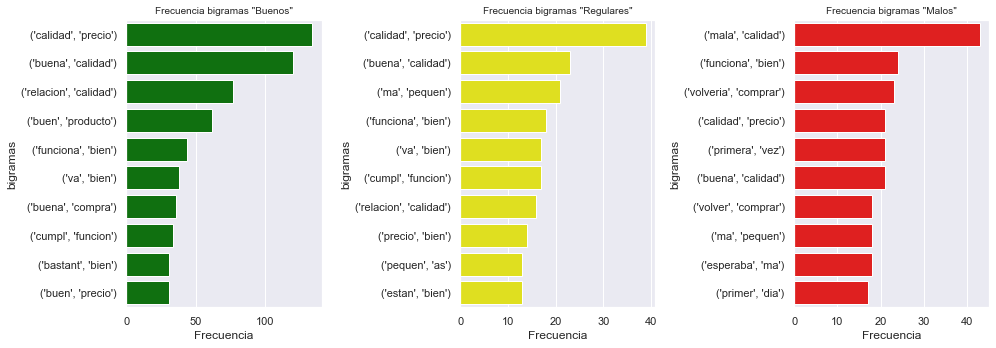

In [21]:
frecuencia_bigramas_bueno = nltk.FreqDist(bueno_bigramas)
dataframe_bigramas_bueno = pd.DataFrame(list(frecuencia_bigramas_bueno.items()), columns = ["Palabra","Frecuencia"])
dataframe_bigramas_bueno.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_bigramas_bueno.reset_index(drop = True, inplace=True)
frecuencia_bigramas_regular = nltk.FreqDist(regular_bigramas)
dataframe_bigramas_regular = pd.DataFrame(list(frecuencia_bigramas_regular.items()), columns = ["Palabra","Frecuencia"])
dataframe_bigramas_regular.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_bigramas_regular.reset_index(drop = True, inplace=True)
frecuencia_bigramas_malo = nltk.FreqDist(malo_bigramas)
dataframe_bigramas_malo = pd.DataFrame(list(frecuencia_bigramas_malo.items()), columns = ["Palabra","Frecuencia"])
dataframe_bigramas_malo.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_bigramas_malo.reset_index(drop = True, inplace=True)

num_ngrams = 10

plt.figure(figsize = (14,5))
plt.subplot(1,3,1)
sns.barplot(y = dataframe_bigramas_bueno.iloc[:num_ngrams].Palabra, x = dataframe_bigramas_bueno.iloc[:num_ngrams].Frecuencia,color='green')
plt.title('Frecuencia bigramas "Buenos"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('bigramas')
plt.tight_layout()

plt.subplot(1,3,2)
sns.barplot(y = dataframe_bigramas_regular.iloc[:num_ngrams].Palabra, x = dataframe_bigramas_regular.iloc[:num_ngrams].Frecuencia,color='yellow')
plt.title('Frecuencia bigramas "Regulares"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('bigramas')
plt.tight_layout()


plt.subplot(1,3,3)
sns.barplot(y = dataframe_bigramas_malo.iloc[:num_ngrams].Palabra, x = dataframe_bigramas_malo.iloc[:num_ngrams].Frecuencia,color='red')
plt.title('Frecuencia bigramas "Malos"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('bigramas')
plt.tight_layout()
plt.show()

Encuentro coherencia en los brigramas.  
Si bien hay varias cadenas que tal vez se repitan, podemos ver diferencias en la frecuencia. Por ejemplo, para el caso de las críticas "Buenas" vemos una clara predominancia de las cadenas 'calidad-precio' y 'buena-calidad'. Además, se observa que en la mayoría tenemos la palabra 'buen' o 'bien' lo cual refuerza nuestra hipótesis.  
Respecto de los bigramas "Regulares", continúa siendo la calificación más confusa de las tres pero también mantiene coherencia. Aquí ya vemos que la frecuencia es mas pareja y aparece menos veces la palabra 'bien' o 'buen'.  
Finalmente, si vemos los bigramas "Malos" vemos que la frecuencia también está más distribuída pero tiene un poco más de peso la cadena 'mala-calidad'.

##### TRIGRAMAS

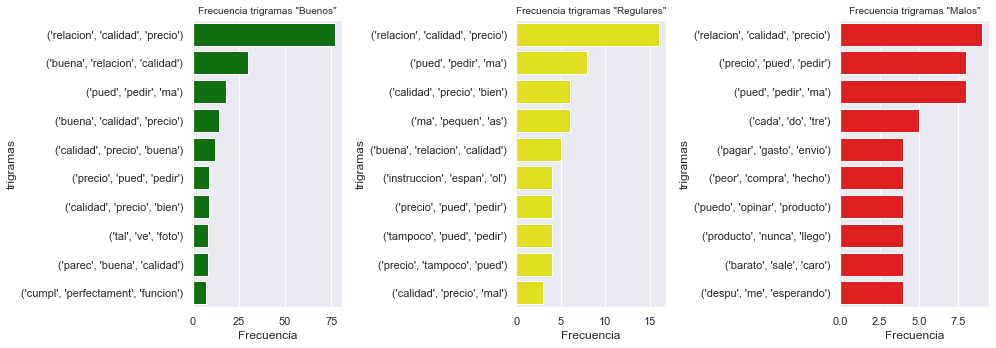

In [22]:
frecuencia_trigramas_bueno = nltk.FreqDist(bueno_trigramas)
dataframe_trigramas_bueno = pd.DataFrame(list(frecuencia_trigramas_bueno.items()), columns = ["Palabra","Frecuencia"])
dataframe_trigramas_bueno.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_trigramas_bueno.reset_index(drop = True, inplace=True)
frecuencia_trigramas_regular = nltk.FreqDist(regular_trigramas)
dataframe_trigramas_regular = pd.DataFrame(list(frecuencia_trigramas_regular.items()), columns = ["Palabra","Frecuencia"])
dataframe_trigramas_regular.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_trigramas_regular.reset_index(drop = True, inplace=True)
frecuencia_trigramas_malo = nltk.FreqDist(malo_trigramas)
dataframe_trigramas_malo = pd.DataFrame(list(frecuencia_trigramas_malo.items()), columns = ["Palabra","Frecuencia"])
dataframe_trigramas_malo.sort_values('Frecuencia', ascending=False, inplace = True)
dataframe_trigramas_malo.reset_index(drop = True, inplace=True)

num_ngrams = 10

plt.figure(figsize = (14,5))
plt.subplot(1,3,1)
sns.barplot(y = dataframe_trigramas_bueno.iloc[:num_ngrams].Palabra, x = dataframe_trigramas_bueno.iloc[:num_ngrams].Frecuencia,color='green')
plt.title('Frecuencia trigramas "Buenos"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('trigramas')
plt.tight_layout()

plt.subplot(1,3,2)
sns.barplot(y = dataframe_trigramas_regular.iloc[:num_ngrams].Palabra, x = dataframe_trigramas_regular.iloc[:num_ngrams].Frecuencia,color='yellow')
plt.title('Frecuencia trigramas "Regulares"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('trigramas')
plt.tight_layout()


plt.subplot(1,3,3)
sns.barplot(y = dataframe_trigramas_malo.iloc[:num_ngrams].Palabra, x = dataframe_trigramas_malo.iloc[:num_ngrams].Frecuencia,color='red')
plt.title('Frecuencia trigramas "Malos"', fontsize=10)
plt.xlabel('Frecuencia')
plt.ylabel('trigramas')
plt.tight_layout()
plt.show()

Los trigramas mantienen la coherencia que ya vimos anteriormente.  
Algunos que particularmente llaman la atención y refuerzan lo que vimos en los bigramas son por ejemplo:  
* 'tampoco-puedo-pedir' --> "Regular"  
* 'barato-sale-caro' --> "Malo"  
* 'peor-compra-hecho' --> "Malo"  
* 'producto-nunca-llego' --> "Malo"

Ahora aplicaremos la misma secuencia para el dataset entero y agregamos al dataset una columna llamado `review_stemming` que contenga los titulares stemmizados

In [23]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
for review in range(amazon_dataset.shape[0]):
    review = amazon_dataset.iloc[review].review_body
    # -> NFD y eliminar diacríticos
    review = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", review), 0, re.I)
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review = re.sub("[^a-zA-Z]"," ",str(review))
    # -> NFC
    review = normalize( 'NFC', review)
    # -> Minúscula
    review = review.lower()
    # Tokenizamos para separar las palabras del titular
    review = nltk.tokenize.word_tokenize(review)
    # Sacamos las Stopwords
    review = [word for word in review if word not in stop_words]
         
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in  review]
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)

In [24]:
amazon_dataset["review_stemming"] = review_list
amazon_dataset.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,calificacion,review_stemming
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home,Bueno,encantado cesta llegado impec taman util pesa ...
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera,Bueno,desempen funcion correctament
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy,Bueno,encantado diadema flore tal vienen imagen veni...
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless,Bueno,gustan funda tpu funda normalment fina colorid...
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel,Bueno,articulo cumplido expectativa deseaba


## Modelos de Machine Learning 

#### Vectorización

Como ya mencionamos en la introducción, la técnica de vectorización que mejores resultados arroja es TF-IDF.

TF-IDF significa _"Term Frequency-Inverse Document Frequency"_  

Term Frequency: Cuántas veces un término aparece en un documento. La importancia de esto es que se supone que mientras más veces aparece, más importante es ese término en ese documento.

Sin Embargo, hay términos (como los artículos "la", "el", o las preposiciones "a", "por") que tienen alta frecuencia en todos los textos. Si les asignamos un puntaje alto, no ganaremos información con respecto a cuál es el tópico del documento.  
Aquí participa la segunda parte de la palabra, IDF: Inverse Document Frequency. Esto significa que se compara la frecuencia de la palabra en ese documento con la frecuencia en todo el corpus de documentos. A mayor frecuencia de la palabra en todos los documentos, menor puntaje tendrá. Así evitamos puntuar alto a stop words o palabras que no agregan información sobre ese documento específico.

a. Tomamos la lista de palabras y el vector que nos dice la cantidad de stars del artículo

In [25]:
review_list = list(amazon_dataset['review_stemming'].values)
stem_calificacion = amazon_dataset['calificacion'].values

b. Importamos los módulos de TF-IDF y generamos vectores

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000)

lemm_tfidf_matriz_review = tfidf.fit_transform(review_list)

# Tomamos las palabras
lemm_tfidf_words = tfidf.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",lemm_tfidf_words[0:50])

50 palabras mas usadas:  ['abajo', 'abierta', 'abierto', 'abr', 'abrir', 'acaba', 'acabado', 'acabo', 'accesorio', 'aceit', 'acept', 'aconsejo', 'ada', 'adapta', 'adaptador', 'adecuado', 'adema', 'adhesivo', 'ado', 'agrad', 'agua', 'aguanta', 'agujero', 'ahi', 'ahora', 'air', 'ajust', 'ajusta', 'ajustar', 'alguien', 'algun', 'alguna', 'almohada', 'alta', 'altavoz', 'alto', 'altura', 'amazon', 'an', 'ancho', 'antena', 'anterior', 'anuncio', 'apaga', 'aparato', 'aparec', 'apart', 'apena', 'aplicacion', 'app']


#### Modelado

Ahora sí estamos listos para comenzar con nuestros modelos de ML.  
La métrica que utilizaré para comparar los modelos es accuracy. La misma nos indica, de todas las clases, cuánto predijimos correctamente. Debería ser lo más alto posible.

a. Primero, como siempre, separamos en test y train.

In [27]:
X = lemm_tfidf_matriz_review.toarray()
y = stem_calificacion

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

b. Importamos las librerías y/o modulos necesarios para los modelos e optimización que vamos a realizar

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score 
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize

Utilizaremos los mismos modelos que se utilizaron en el proyecto N°3 (Random Forest, XGBoost y SVC) y como dijimos en la introducción utilizaremos la librería skopt para optimizaciones.


`Scikit-Optimize` es una librería open-source basada en Scipy, NumPy y Scikit-Learn que proporciona un conjunto de herramientas pueden utilizarce para el ajuste de hiperparámetros. 

`Skopt` precisa que sean definidas cuatro características:
   1) Espacio: Puede contener una o varias dimensiones y existen diferentes funciones para definirlo. En este caso utilizaremos:
       - Integer: Dimensión de espacio de búsqueda que puede tomar valores enteros.
       - Categorical: dimensión del espacio de búsqueda que puede adoptar valores categóricos.
       
       
   2) BayesSearchCV: La clase BayesSearchCV proporciona una interfaz similar GridSearchCV o RandomizedSearchCV pero realiza una optimización bayesiana sobre hiperparámetros. A diferencia de GridSearchCV, no se prueban todos los valores de los parámetros, sino que se muestrea un número fijo de configuraciones de parámetros a partir de las distribuciones especificadas. El número de ajustes de parámetros que se prueban viene dado por n_iter.
   
   3) Función objetivo: Esta es una función que será llamada por el procedimiento de búsqueda, recibe valores de hiperparámetros como entrada del espacio de búsqueda y devuelve la pérdida (cuanto menor, mejor). Esto significa que durante el proceso de optimización, entrenamos el modelo con valores de hiperparámetros seleccionados y predecimos la característica objetivo y luego evaluamos el error de predicción y se lo devolvemos al optimizador. El optimizador decidirá qué valores comprobar y volver a iterar.
   
   4) Optimizador: es la función que realiza el proceso de optimización de hiperparámetros bayesianos. La función de optimización itera en cada modelo y el espacio de búsqueda para optimizar y luego minimiza la función objetivo.
Hay diferentes funciones de optimización proporcionadas por la biblioteca scikit-Optimize, en este caso utilizaremos gp_minimize (optimización bayesiana mediante procesos gaussianos).
       






### Modelo 1: Random Forest Classifier

In [29]:
# Definimos el espacio de búsqueda para hiperparámetros
search_space_rf = list()
search_space_rf.append(Categorical([100, 200, 300, 400], name='n_estimators'))
search_space_rf.append(Categorical(['gini', 'entropy'], name='criterion'))
search_space_rf.append(Integer(1, 9, name='max_depth'))

In [30]:
#Nuestra función para minimizar se llama evalute_model y el algoritmo de clasificación para optimizar su hiperparámetro es Random Forest . 
#Utilizo la validación cruzada para evitar el sobreajuste y luego la función devolverá valores de pérdida.
@use_named_args(search_space_rf)
def evaluate_model(**params):
    # Configuramos el modelo con hiperparámetros específicos
    clf = RandomForestClassifier(**params, n_jobs=-1)
    acc_rf = cross_val_score(clf, Xtrain, ytrain, scoring="accuracy").mean()
    #skpot minimiza la función, por eso agregamos signo negativo a acc.
    return -acc_rf

In [31]:
# performamos optimización

result_rf = gp_minimize(
    func=evaluate_model,
    dimensions=search_space_rf,
    n_calls=10,
    random_state=42,
    verbose=True,
    n_jobs=1,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 26.9631
Function value obtained: -0.6135
Current minimum: -0.6135
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.8480
Function value obtained: -0.6028
Current minimum: -0.6135
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.4436
Function value obtained: -0.6040
Current minimum: -0.6135
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.5154
Function value obtained: -0.6150
Current minimum: -0.6150
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 28.9013
Function value obtained: -0.6155
Current minimum: -0.6155
Iteration No: 6 star

In [32]:
# Resumen:

print('Best Accuracy: %.3f' % (result_rf.fun)) 
print('Best Parameters: %s' % (result_rf.x))

Best Accuracy: -0.617
Best Parameters: [400, 'entropy', 8]


Después de realizar la optimización de hiperparámetros, la pérdida es -0,618, lo que significa que el rendimiento del modelo tiene una precisión del 61,8%.

Podemos ver también el gráfico de convergencia, el cual nos muestra los valores de la función en diferentes iteraciones durante el proceso de optimización.



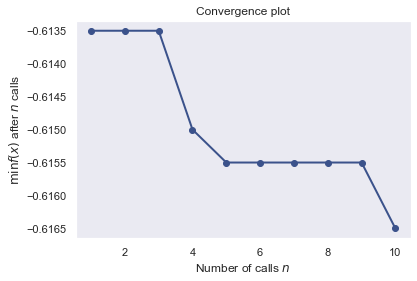

In [33]:
# plot convergence 

from skopt.plots import plot_convergence

plot_convergence(result_rf) 

Vamos a realizar el mismo procedimiento para el resto de los modelos.

### Modelo 2: XGBoost

In [34]:
import xgboost as xgb

# Definimos el espacio de búsqueda para hiperparámetros
search_space_xgb = list()
search_space_xgb.append(Categorical([50, 100, 150, 200], name='n_estimators'))
search_space_xgb.append(Categorical(range (3, 10), name='max_depth'))
search_space_xgb.append(Categorical([0.01, 0.1, 0.2, 0.3], name='learning_rate'))
search_space_xgb.append(Categorical([i/10.0 for i in range(1,3)], name='gamma'))
search_space_xgb.append(Categorical([i/10.0 for i in range(1,3)], name='colsample_bytree'))

#Nuestra función para minimizar se llama evalute_model y el algoritmo de clasificación para optimizar su hiperparámetro es Random Forest . 
#Utilizo la validación cruzada para evitar el sobreajuste y luego la función devolverá valores de pérdida.
@use_named_args(search_space_xgb)
def evaluate_model(**params):
    # Configuramos el modelo con hiperparámetros específicos
    xgboost = xgb.XGBClassifier(**params, n_jobs=-1)
    acc_xgb = cross_val_score(xgboost, Xtrain, ytrain, scoring="accuracy").mean()
    #skpot minimiza la función, por eso agregamos signo negativo a acc.
    return -acc_xgb

# performamos optimización

result_xgb = gp_minimize(
    func=evaluate_model,
    dimensions=search_space_xgb,
    n_calls=10,
    random_state=42,
    verbose=True,
    n_jobs=1,
)

# Resumen

print('Best Accuracy: %.3f' % (result_xgb.fun)) 
print('Best Parameters: %s' % (result_xgb.x))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 47.0400
Function value obtained: -0.6318
Current minimum: -0.6318
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.2003
Function value obtained: -0.6220
Current minimum: -0.6318
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 27.6889
Function value obtained: -0.6302
Current minimum: -0.6318
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 78.0408
Function value obtained: -0.6195
Current minimum: -0.6318
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 27.4492
Function value obtained: -0.6310
Current minimum: -0.6318
Iteration No: 6 star

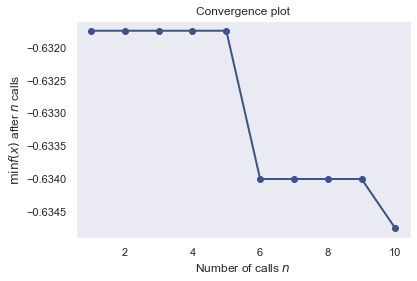

In [35]:
plot_convergence(result_xgb)

### Modelo N°3: SVC

In [36]:
%%time

from sklearn.svm import SVC

# Definimos el espacio de búsqueda para hiperparámetros
search_space_svc = list()
search_space_svc.append(Categorical(['poly', 'rbf', 'sigmoid'], name='kernel'))
search_space_svc.append(Integer(5, 10, name='C'))

#Nuestra función para minimizar se llama evalute_model y el algoritmo de clasificación para optimizar su hiperparámetro es Random Forest . 
#Utilizo la validación cruzada para evitar el sobreajuste y luego la función devolverá valores de pérdida.
@use_named_args(search_space_svc)
def evaluate_model(**params):
    # Configuramos el modelo con hiperparámetros específicos
    svc = SVC(**params)
    acc_svc = cross_val_score(svc, Xtrain, ytrain, scoring="accuracy").mean()
    return -acc_svc

# performamos optimización

result_svc = gp_minimize(
    func=evaluate_model,
    dimensions=search_space_svc,
    n_calls=10,
    random_state=42,
    verbose=True,
    n_jobs=1,
)

# Resumen

print('Best Accuracy: %.3f' % (result_svc.fun)) 
print('Best Parameters: %s' % (result_svc.x))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 139.2690
Function value obtained: -0.5978
Current minimum: -0.5978
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 143.5334
Function value obtained: -0.5840
Current minimum: -0.5978
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 239.8613
Function value obtained: -0.6407
Current minimum: -0.6407
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 236.5344
Function value obtained: -0.6410
Current minimum: -0.6410
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 236.6826
Function value obtained: -0.6268
Current minimum: -0.6410
Iteration No: 6

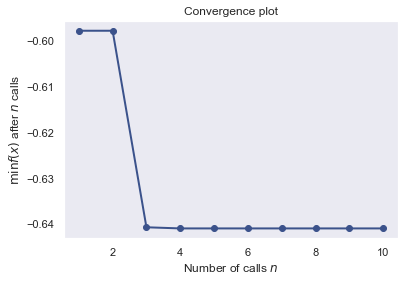

In [37]:
plot_convergence(result_svc)

### CONCLUSIÓN

Finalizado el proceso de hiperoptimización podemos ver que el modelo de mejor performance es el SVC con un accruacy de 64,1% cuando sus hiperparámetros toman los valores kernel=rbf y C=7.

En segundo lugar, podemos concluir también que las dos hipótesis planteadas al principio son verdaderas ya que se han reducido los tiempos en un 84,3% y se ha mejorado el accuracy del modelo en 0.236